# Robot Intelligence Spring 2023: Tutorial 4

In this tutorial, we'll be discussing Jacobians, which we can use to find numerical solutions to Inverse-Kinematics problems in robotics.

## Review of Lecture Concepts

### What is a Jacobian?



A *jacobian*, typically denoted as $\mathbf{J}$, is
a matrix that represents all of the first-order partial derivatives of some vector-valued function. More precisely, given a vector valued function $\mathbf{f}: \mathbb{R}^n \mapsto \mathbb{R}^m$, the jacobian matrix of $\mathbf{f}$ will by a $m \times n$ matrix whose $(i, j)$th entry is $\mathbf{J}_{ij} = \frac{\partial \mathbf{f}_i}{\partial x_j}$. Written out, we have:

$$\mathbf{J} = \begin{bmatrix}\frac{\partial\mathbf{f} }{\partial x_1} &  \dots & \frac{\partial\mathbf{f} }{\partial x_n}
\end{bmatrix} = \begin{bmatrix} \nabla^T \mathbf{f}_1 \\ \vdots \\ \nabla^T \mathbf{f}_m\end{bmatrix} = \begin{bmatrix}\frac{\partial \mathbf{f}_1}{\partial x_1} & \dots & \frac{\partial  \mathbf{f}_1}{\partial x_n} \\ \vdots & \ddots & \vdots \\ \frac{\partial \mathbf{f}_m}{\partial x_1} & \dots & \frac{\partial f_m}{\partial x_n}\end{bmatrix},$$

where $\nabla^T \mathbf{f}_i$ corresponds to the transpose of the gradient of the $i$th component of $\mathbf{f}$.

### Why do we care about Jacobians in the context of robotics?


Jacobians can aid us in determining analytic and/or numerical solutions to the **fundamental robotics control problem: *inverse kinematics***.

### The Inverse Kinematics Problem

Previously in the course, we learned about forward kinematics, i.e. how to derive kinematic equations relating joint parameters to the rotation and position of an end effector by chaining together homogeneous transformations with matrix products. 


Let $\mathbf{q} \in \mathbb{R}^n$ denote the full vector of joint parameters for a real-world robot with $n$ degrees of freedom (DOF), and let $T$ represent the homogeneous transformation matrix corresponding to the full configuration of the end effector in the base reference frame, i.e.

$$\boldsymbol T \ = \begin{bmatrix} \boldsymbol R_{EE} & \boldsymbol s \\
\boldsymbol 0 & 1 \end{bmatrix} \in SE(3),$$

where $SE(3)$ denotes the group of all rigid body transformations, known as the special Euclidean group on $\mathbb{R}^3$, a subgroup

Last week, we saw that forward kinematics yields a map relating the joint parameter vector to the homogeneous transformation matrix of the end effector, $\mathbf{f}: \mathbb{R}^n \mapsto SE(3)$ with $\mathbf{f}(\mathbf{q}) = T$.

But what is the actual number of free parameters in $\boldsymbol T$? 

Well, our real-world robot's end-effector will have a 3-D position $\boldsymbol s \in \mathbb{R}^3$ and a $3 \times 3$ rotation matrix $\boldsymbol R_{EE}$, which as we learned in last tutorial, can be uniquely decomposed into rotations about the $x$, $y$, and $z$ axes in our base reference frame, with corresponding angles $\theta_x, \theta_y, \theta_z$. In summary, our real-world end-effector's position and orientation can be uniquely described with six parameters, which we can write in vector form $\mathbf{x} = \begin{bmatrix}s_x, s_y, s_z, \theta_x, \theta_y, \theta_z\end{bmatrix}^T$.

Thus, we express the vector-to-matrix map $\mathbf{f}$ in an equivalent *vector-valued* form $\widetilde{\mathbf{f}}$,

$$\widetilde{\mathbf{f}}(\mathbf{q}) = \widetilde{\mathbf{f}}\left(\begin{bmatrix}\mathbf{q}_1 \\ \vdots \\ \mathbf{q}_n\end{bmatrix}\right) = \begin{bmatrix}s_x \\ s_y \\ s_z \\ \theta_x\\ \theta_y\\\theta_z\end{bmatrix} = \mathbf{x}$$

Fix a desired end effector configuration $\mathbf{x} \in \mathbb{R}^6$. Suppose we want to solve the inverse kinematics problem, and find a value $\mathbf{q}^*$ such that

$$\mathbf{x} - \widetilde{\mathbf{f}}(\mathbf{q}^*) = 0$$

If you've taken optimization before, the equation above should strike you as familiar...indeed, inverse kinematics is just a [root-finding problem](https://en.wikipedia.org/wiki/Root-finding_algorithms), one of the most fundamental and deeply studied problems in optimization! 

As such, there's a very broad class of numerical algorithms we can apply here, from Newton's method to fixed point iteration, and so on. 

We can group root-finding algorithms across a two groups: gradient-base methods and gradient-free methods, i.e. methods which require the derivative of the target function to be well-defined, and those which do not. **In fact, there is a gradient-base algorithm that we've talked quite a bit about in the course already which we can apply here: gradient descent**.

### Gradient Descent

How would this work?

In gradient descent, the goal is to minimize the value of some objective function, e.g. the *loss-function* in the context of deep learning. We compute gradients of this function with respect to our parameters, and then take steps in the direction of the negative gradient, our step size regulated by the *learning rate*, $\nu$.

In the context of inverse kinematics, we can view the squared error between the end-effector position corresponding to some candidate vector of joint parameter values $\mathbf{q}$ and the target end-effector configuration $\mathbf{x}$ as our objective function,

$$\mathcal{L}(\mathbf{q}) = ||\mathbf{x} - \widetilde{f}(\mathbf{q})||^2$$

What is the gradient of this expression with respect to the joint parameter vector? Well, we can write it as

$$\begin{align}\nabla_{\mathbf{q}} \mathcal{L}(\mathbf{q}) &= \nabla_{\mathbf{q}}(\mathbf{x} - \widetilde{\mathbf{f}}(\mathbf{q}))^T (\mathbf{x} - \widetilde{\mathbf{f}}(\mathbf{q}))\\ &= - 2 \nabla_{\mathbf{q}}\widetilde{\mathbf{f}}(\mathbf{q}) \cdot (\mathbf{x} - \widetilde{\mathbf{f}}(\mathbf{q}))\\
&= - 2 \mathbf{J}^T  (\mathbf{x} - \widetilde{\mathbf{f}}(\mathbf{q})),\end{align}$$

yielding updates,

$$\begin{align}\mathbf{q}_{i} &\gets \mathbf{q}_{i-1} + \nu \nabla_{\mathbf{q_{i-1}}} \mathcal{L}(\mathbf{q}_{i-1})\\
 \mathbf{q}_{i} &\gets \mathbf{q}_{i-1} + 2\nu \mathbf{J}^T  (\mathbf{x} - \widetilde{\mathbf{f}}(\mathbf{q}_{i-1}))\end{align}$$

Indeed, the jacobian does make an appearance here!

### Newton-Raphson method

Another method we can use here is the classic of root-finding: the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method).

In this method, we start off with a guess for our parameter vector and proceed by approximating $\mathbf{f}$ by its tangent line, computing this tangent line's x-intercept. This process of computation leaves us with a better approximation to the original function's root. As in gradient-descent, we employ a parameter $\alpha$, regulating the "step-size" associated with our updates.

$$\begin{align}\mathbf{q}_i &\gets \mathbf{q}_{i-1} - \alpha \cdot \frac{\mathbf{x} - \mathbf{f}(\mathbf{q})}{\nabla_{\mathbf{q}}(\mathbf{x} - \mathbf{f}(\mathbf{q}))}\\
\mathbf{q}_i &\gets \mathbf{q}_{i-1}  + \alpha \cdot \frac{\mathbf{x} -\mathbf{f}(\mathbf{q})}{\nabla_{\mathbf{q}}( \mathbf{f}(\mathbf{q}) - \mathbf{x})}
\\
\mathbf{q}_i &\gets \mathbf{q}_{i-1}  + \alpha \cdot \mathbf{J}^{-1} (\mathbf{x} -\mathbf{f}(\mathbf{q})) \end{align}$$

But wait, there's a problem! What if $\mathbf{J}^{-1}$ is not well-defined, i.e. $\mathbf{J}$ is singular? To account for such cases, instead of inverting $\mathbf{J}$ at each timestep, we can rely on the [pseudo-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of the Jacobian, yielding the update rule below 
$$\mathbf{q}_i \gets \mathbf{q}_{i-1}  - \alpha \cdot \mathbf{J}^{\dagger} (\mathbf{f}(\mathbf{q}) - \mathbf{x})$$

## The RRR and Jacobians

Recall the **RRR (three revolute joint manipulator)** presented in the last tutorial.

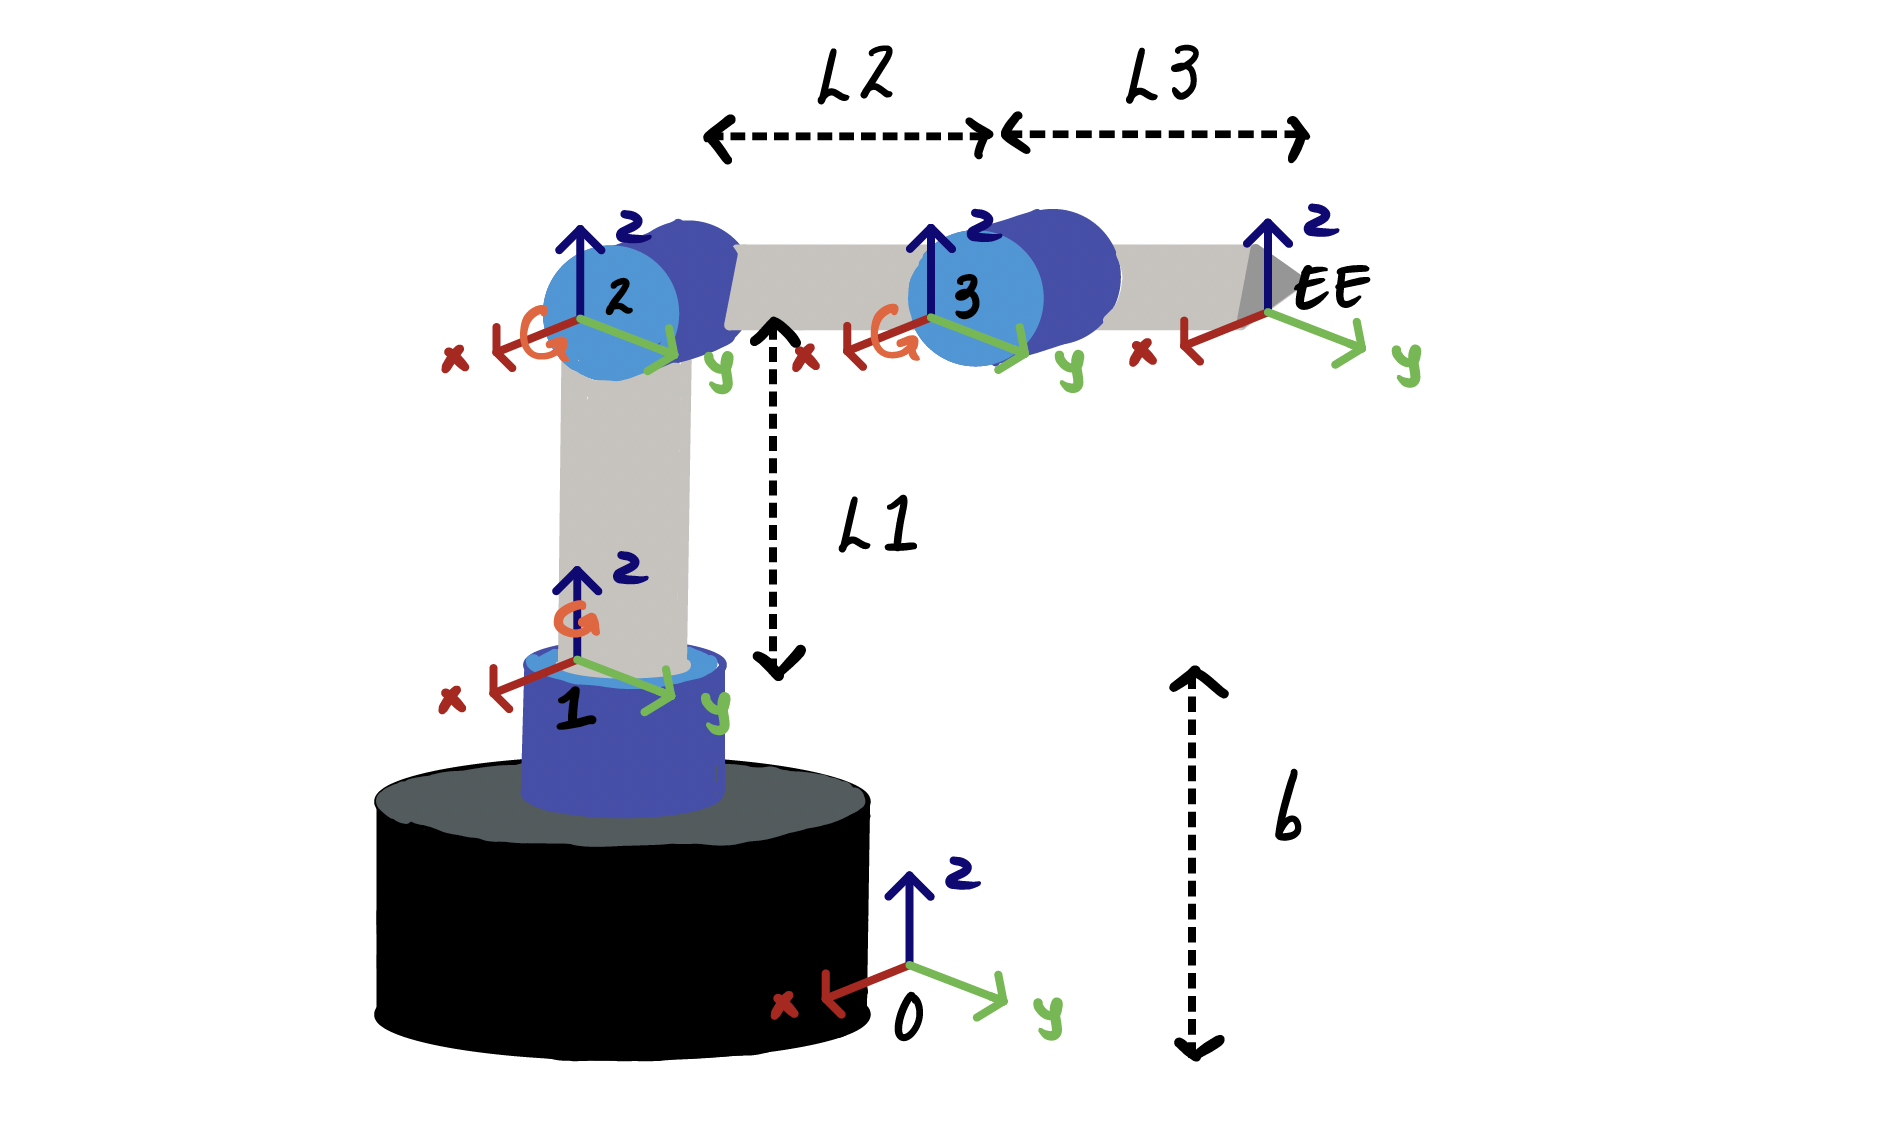

### Last Time: FK with `numpy`

Last time, we saw that we can write out the forward kinematics for this robot as shown below:

$$\begin{align}
T^{0}_{EE} &= A_{1}A_{2}A_{3}A_{EE}\\
&= T_{translation}(b, z) T_{rotation}(\theta_1, z) T_{translation}(L1, z) T_{rotation}(\theta_2, x) T_{translation}(L2, y) T_{rotation}(\theta_3, x)T_{translation}(L3, y)
\end{align}$$

We also saw that we can express the forward kinematics equation with `numpy` via code as shown below, relating the joint parameter vector to the vector $\mathbf{x} = \begin{bmatrix}s_x, s_y, s_z, \theta_x, \theta_y, \theta_z\end{bmatrix}^T$.

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def forward_kinematics_numpy(joint_parameters):
  b, l1, l2, l3, theta1, theta2, theta3 = joint_parameters

  ### transformation from base coordinates to those of joint 1
  a1 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, b],
    [0, 0, 0, 1]
  ]).dot(
      np.array([
          [np.cos(theta1), -np.sin(theta1), 0, 0],
          [np.sin(theta1), np.cos(theta1), 0, 0],
          [0, 0, 1, 0],
          [0, 0, 0, 1]
      ])
  )


  ### transformation from joint 1 coordinates to those of joint 2
  a2 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, l1],
    [0, 0, 0, 1]
  ]).dot(
      np.array([
          [1, 0, 0, 0],
          [0, np.cos(theta2), -np.sin(theta2), 0,],
          [0, np.sin(theta2), np.cos(theta2), 0],
          [0, 0, 0, 1]
      ])
  )


  ### transformation from joint 2 coordinates to those of joint 3
  a3 = np.array([
      [1, 0, 0, 0],
      [0, 1, 0, l2],
      [0, 0, 1, 0],
      [0, 0, 0, 1]
  ]).dot(
      np.array([
          [1, 0, 0, 0],
          [0, np.cos(theta3), -np.sin(theta3), 0,],
          [0, np.sin(theta3), np.cos(theta3), 0],
          [0, 0, 0, 1]
      ])
  )


  ### transformation from joint 3 coordinates to those of the end effector
  aee = np.array([
      [1, 0, 0, 0],
      [0, 1, 0, l3],
      [0, 0, 1, 0],
      [0, 0, 0, 1]
  ])


  ### recombine kinematic chain
  result = a1.dot(a2.dot(a3.dot(aee)))
  pos = result[:3, 3]
  R = result[:3, :3]
  return pos, R

In [ ]:
#### Example paramters + output
b = 12
l1 = 10
l2 = 6
l3 = 7

# Angles in radians
theta1 = 20 * np.pi / 180
theta2 = 30 * np.pi / 180
theta3 = 15 * np.pi / 180

forward_kinematics_numpy([b, l1, l2, l3, theta1, theta2, theta3])

(array([-3.47010213,  9.53402726, 29.94974747]),
 array([[ 0.93969262, -0.24184476,  0.24184476],
        [ 0.34202014,  0.66446302, -0.66446302],
        [ 0.        ,  0.70710678,  0.70710678]]))

### Transferring FK to `torch`

Now, let's `torch`-ify this function, so that we can employ torch's automatic differentiation to get estimates of the Jacobian directly.

In [ ]:
# HELPER METHODS FOR CONVERTING ROTATION MATRICES TO EULER ANGLES FROM PYTORCH3D 
# repo link: https://github.com/facebookresearch/pytorch3d/blob/main/pytorch3d/transforms/rotation_conversions.py

def _index_from_letter(letter: str) -> int:
    if letter == "X":
        return 0
    if letter == "Y":
        return 1
    if letter == "Z":
        return 2
    raise ValueError("letter must be either X, Y or Z.")

def _angle_from_tan(
    axis: str, other_axis: str, data, horizontal: bool, tait_bryan: bool
) -> torch.Tensor:
    """
    Extract the first or third Euler angle from the two members of
    the matrix which are positive constant times its sine and cosine.
    Args:
        axis: Axis label "X" or "Y or "Z" for the angle we are finding.
        other_axis: Axis label "X" or "Y or "Z" for the middle axis in the
            convention.
        data: Rotation matrices as tensor of shape (..., 3, 3).
        horizontal: Whether we are looking for the angle for the third axis,
            which means the relevant entries are in the same row of the
            rotation matrix. If not, they are in the same column.
        tait_bryan: Whether the first and third axes in the convention differ.
    Returns:
        Euler Angles in radians for each matrix in data as a tensor
        of shape (...).
    """

    i1, i2 = {"X": (2, 1), "Y": (0, 2), "Z": (1, 0)}[axis]
    if horizontal:
        i2, i1 = i1, i2
    even = (axis + other_axis) in ["XY", "YZ", "ZX"]
    if horizontal == even:
        return torch.atan2(data[..., i1], data[..., i2])
    if tait_bryan:
        return torch.atan2(-data[..., i2], data[..., i1])
    return torch.atan2(data[..., i2], -data[..., i1])

def matrix_to_euler_angles(matrix: torch.Tensor, convention: str) -> torch.Tensor:
    """
    Convert rotations given as rotation matrices to Euler angles in radians.
    Args:
        matrix: Rotation matrices as tensor of shape (..., 3, 3).
        convention: Convention string of three uppercase letters.
    Returns:
        Euler angles in radians as tensor of shape (..., 3).
    """
    
    i0 = _index_from_letter(convention[0])
    i2 = _index_from_letter(convention[2])
    tait_bryan = i0 != i2
    if tait_bryan:
        central_angle = torch.asin(
            matrix[..., i0, i2] * (-1.0 if i0 - i2 in [-1, 2] else 1.0)
        )
    else:
        central_angle = torch.acos(matrix[..., i0, i0])

    o = (
        _angle_from_tan(
            convention[0], convention[1], matrix[..., i2], False, tait_bryan
        ),
        central_angle,
        _angle_from_tan(
            convention[2], convention[1], matrix[..., i0, :], True, tait_bryan
        ),
    )
    return torch.stack(o, -1)

# END HELPER METHODS

In [ ]:
from torch.nn.modules.padding import ReflectionPad3d
import torch
import torch.nn.functional as F

def forward_kinematics_torch(joint_parameters):
  def _get_z_translation(t):
    return torch.eye(4) + F.pad(t, (3, 0, 2, 1))

  def _get_y_translation(t):
    return torch.eye(4) + F.pad(t, (3, 0, 1, 2))

  def _get_z_rotation(theta):
    s = torch.sin(theta)
    c = torch.cos(theta)
    return torch.eye(4) + F.pad(torch.stack([torch.stack([c - 1, -s]), torch.stack([s, c - 1])]), (0, 2, 0, 2))

  def _get_x_rotation(theta):
    s = torch.sin(theta)
    c = torch.cos(theta)
    return torch.eye(4) + F.pad(torch.stack([torch.stack([c - 1, -s]),torch.stack([s, c - 1])]), (1, 1, 1, 1)) 


  ### transformation from base coordinates to those of joint 1
  t1 = _get_z_translation(joint_parameters.unsqueeze(1).unsqueeze(1)[0])
  r1 = _get_z_rotation(joint_parameters[4])
  a1 = t1.matmul(r1)

  ### transformation from joint 1 coordinates to those of joint 2
  t2 = _get_z_translation(joint_parameters.unsqueeze(1).unsqueeze(1)[1])
  r2 = _get_x_rotation(joint_parameters[5])
  a2 = t2.matmul(r2)

  ### transformation from joint 2 coordinates to those of joint 3
  t3 = _get_y_translation(joint_parameters.unsqueeze(1).unsqueeze(1)[2])
  r3 = _get_x_rotation(joint_parameters[6])
  a3 = t3.matmul(r3)

  ### transformation from joint 3 coordinates to those of the end effector
  aee = _get_y_translation(joint_parameters.unsqueeze(1).unsqueeze(1)[3])

  result = a1.matmul(a2.matmul(a3.matmul(aee)))
  pos = result[:3, 3]
  rot = result[:3, :3]
  angles = matrix_to_euler_angles(rot, 'XYZ')

  return torch.hstack([pos, angles])  

In [ ]:
joint_parameters = torch.tensor([b, l1, l2, l3, theta1, theta2, theta3], requires_grad=True)

Let's check that our two implementation agree on the end effector position for our test values.

In [ ]:
np.allclose(forward_kinematics_numpy(joint_parameters.detach().numpy())[0], forward_kinematics_torch(joint_parameters).detach().numpy()[:3])

True

Now, let's import the `jacobian` method from the `autograd` torch sub-library, and see what happens when we use this method to compute the jacobian for the test values

In [ ]:
from torch.autograd.functional import jacobian

J = torch.autograd.functional.jacobian(forward_kinematics_torch, joint_parameters, create_graph=True)

J, J.shape

(tensor([[ 0.0000,  0.0000, -0.2962, -0.2418, -9.5340,  2.7190,  1.6929],
         [ 0.0000,  0.0000,  0.8138,  0.6645, -3.4701, -7.4703, -4.6512],
         [ 1.0000,  1.0000,  0.5000,  0.7071,  0.0000, 10.1459,  4.9497],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.1816,  0.9981,  0.9981],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.6848,  0.2492,  0.2492],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.7510, -0.2414, -0.2414]],
        grad_fn=<ViewBackward0>), torch.Size([6, 7]))

Great, we have a jacobian!

In [ ]:
torch.linalg.pinv(J).shape

torch.Size([7, 6])

### Exercise I: Implement the GD Update Rule

In [ ]:
def gradient_descent_update(old_joint_parameters,
                            target_config=torch.zeros(6,), 
                            lr=0.001):
  #### TO DO: IMPLEMENT THE GRADIENT DESCENT UPDATE RULE AS DERIVED ABOVE  ###
  #### Your code should reference `forward_kinematics_torch` defined above ###
  #### and the `jacobian` method from torch.autograd.functional.           ###
  J = torch.autograd.functional.jacobian(forward_kinematics_torch, 
                                         old_joint_parameters, 
                                         create_graph=True)
  delta = 2 * J.T.matmul((target_config - forward_kinematics_torch(old_joint_parameters)).unsqueeze(1))
  new_joint_parameters = old_joint_parameters + lr * delta.reshape(-1)
  return new_joint_parameters

gradient_descent_update(joint_parameters)

tensor([11.9401,  9.9401,  5.9525,  6.9433,  0.3486,  0.0757,  0.0642],
       grad_fn=<AddBackward0>)

### Excercise II: Implement the Newton-Raphson Update Rule

You may find [this method](https://pytorch.org/docs/stable/generated/torch.linalg.pinv.html#torch-linalg-pinv) useful.

In [ ]:
def newton_raphson_update(old_joint_parameters,
                          target_config=torch.zeros(6,), 
                          alpha=0.1):
  #### TO DO: IMPLEMENT THE NEWTON-RALPHSON UPDATE RULE AS DERIVED ABOVE   ###
  #### Your code should reference `forward_kinematics_torch` defined above ###
  #### and the `jacobian` method from torch.autograd.functional.           ###
  J = torch.autograd.functional.jacobian(forward_kinematics_torch, 
                                         old_joint_parameters, 
                                         create_graph=True)
  delta = torch.linalg.pinv(J).matmul((forward_kinematics_torch(old_joint_parameters) - target_config).unsqueeze(1))
  new_joint_parameters = old_joint_parameters - alpha * delta.reshape(-1)
  return new_joint_parameters

newton_raphson_update(joint_parameters)

tensor([11.4771,  9.4771,  4.9799,  6.0108,  0.3487,  0.4455,  0.2724],
       grad_fn=<SubBackward0>)

### Comparing Gradient Descent vs Newton-Raphson Updates

In [ ]:
def gradient_descent_ik(init_joint_parameters,
                        target_config=torch.zeros(6,),
                        num_iter=1000,
                        lr=0.1):
  q = init_joint_parameters
  for _ in range(num_iter):
    q = gradient_descent_update(q, target_config, lr)
  return q

In [ ]:
def newton_raphson_ik(init_joint_parameters,
                      target_config=torch.zeros(6,),
                      num_iter=1000,
                      alpha=1):
  q = init_joint_parameters
  for _ in range(num_iter):
    q = newton_raphson_update(q, target_config, alpha)
  return q

In [ ]:
target_config = torch.zeros(6,)

In [ ]:
gd = gradient_descent_ik(joint_parameters, target_config=target_config)

In [ ]:
nr = newton_raphson_ik(joint_parameters, target_config=target_config)

In [ ]:
torch.allclose(forward_kinematics_torch(gd), target_config, atol=1e-05)

True

In [ ]:
torch.allclose(forward_kinematics_torch(nr), target_config, atol=1e-05)

True